# Kaggle - Titanic competition dataset

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('gender_submission.csv')

In [3]:
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
786,787,1,3,"Sjoblom, Miss. Anna Sofia",female,18.0,0,0,3101265,7.4958,NaN,S
117,118,0,2,"Turpin, Mr. William John Robert",male,29.0,1,0,11668,21.0000,NaN,S
483,484,1,3,"Turkula, Mrs. (Hedwig)",female,63.0,0,0,4134,9.5875,NaN,S
451,452,0,3,"Hagland, Mr. Ingvald Olai Olsen",male,NaN,1,0,65303,19.9667,NaN,S
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import KFold

In [5]:
def gender_transform(x):
    if x == 'female':
        return 1
    else: 
        return 0
    
train['Gender_Bi'] = train['Sex'].map(gender_transform)
test['Gender_Bi'] = test['Sex'].map(gender_transform)

### Finding Patterns in the name

In [6]:
# Search for context aspects 

titles = ['Miss', 'Mr', 'Master', 'Dr', 'Mrs', 'Rev', 'Countess']


def find_title_in_name(x):
    for title in titles: 
        #print('Finding:', strategy)
        if re.search(title, x): 
            #print('Found:', strategy)
            return title


train['Title'] = train['Name'].map(find_title_in_name)
test['Title'] = test['Name'].map(find_title_in_name)

# Title Categorical Variable Transformation

def title_adjust(y):
    if y == 'Miss':
        return 1
    if y == 'Mr':
        return 2
    if y == 'Master': 
        return 3
    if y == 'Dr': 
        return 4
    if y == 'Mrs': 
        return 5 
    if y == 'Rev':
        return 6
    if y == 'Countess':
        return 7
    
train['Title'] = train['Title'].map(title_adjust)
test['Title'] = test['Title'].map(title_adjust)

train = train.fillna(0)

train['Title'] = train['Title'].astype(np.int64)

## Visualizations

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

### Univariate Exploration

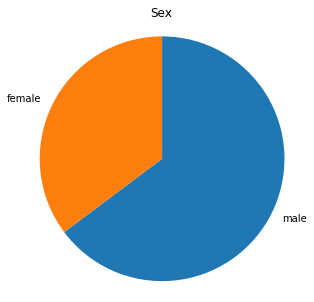

In [8]:
# Piechart Sex

plt.figure(figsize=[5,5])  

plt.title('Sex')  

def pie_sex():
    sorted_counts = train['Sex'].value_counts()
    plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False);
    plt.axis('square');

pie_sex()    

##### Fare Distribution

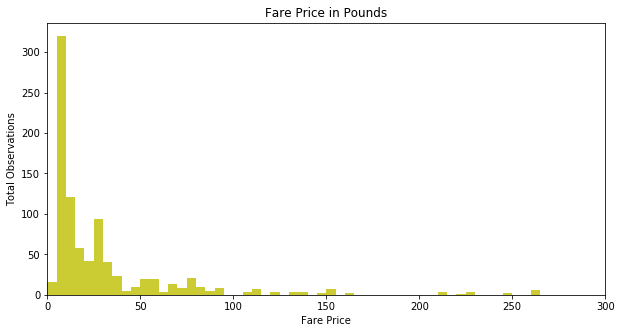

In [32]:
binsize = 5
bins = np.arange(0, train['Fare'].max()+binsize, binsize)

def graph():
    plt.hist(data = train, alpha=0.8, facecolor='y', x = 'Fare', bins = bins)
    
plt.figure(figsize=[10,5])    
plt.title('Fare Price in Pounds')    
plt.ylabel('Total Observations')
plt.xlabel('Fare Price')
plt.xlim([0, 300])


plt.show(graph());

##### Age Distribution

In [44]:
train.query('Age > 0 and Age < 0.5')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender_Bi,Title
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,0,C,0,3


In [50]:
train.query('Age == 0').count()

PassengerId    177
Survived       177
Pclass         177
Name           177
Sex            177
Age            177
SibSp          177
Parch          177
Ticket         177
Fare           177
Cabin          177
Embarked       177
Gender_Bi      177
Title          177
dtype: int64

By doing some research to find if age 0.42 is an error or a baby. I found that the age is correct and set it as the inferior limit. Passengers aged zero were removed to display the Age distribution. 

https://www.encyclopedia-titanica.org/titanic-survivor/assad-alexander-thomas-tannous.html

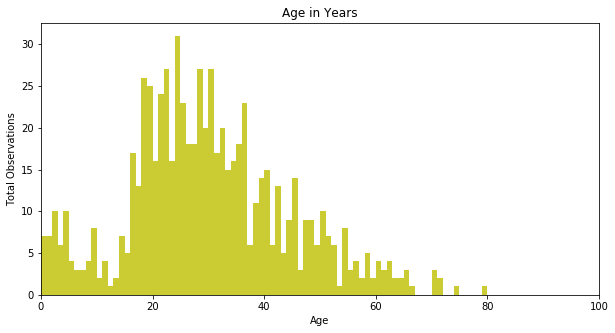

In [45]:
binsize = 1
bins = np.arange(0, train['Age'].max()+binsize, binsize)

train_age_not_zero = train.query('Age > 0.4')

def graph():
    plt.hist(data = train_age_not_zero, alpha=0.8, facecolor='y', x = 'Age', bins = bins)
    
plt.figure(figsize=[10,5])    
plt.title('Age in Years')    
plt.ylabel('Total Observations')
plt.xlabel('Age')
plt.xlim([0, 100])


plt.show(graph());

In [20]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender_Bi,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,0,2


### Bivariate Exploration

In [10]:
import seaborn as sb

numeric_vars = ['Gender_Bi', 'Age', 'Pclass', 'Survived']


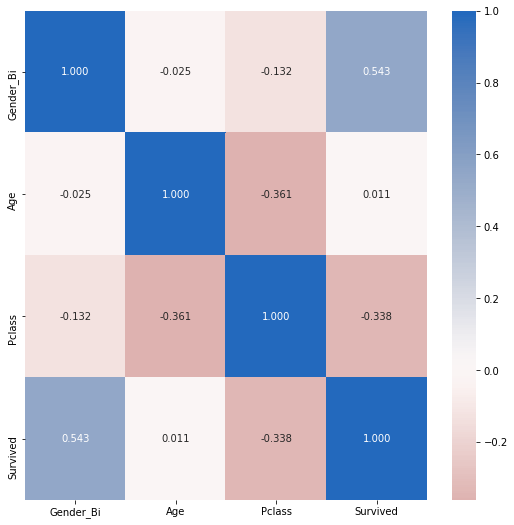

In [11]:
plt.figure(figsize=[9,9])   

def graph():
    sb.heatmap(train[numeric_vars].corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center=0)
    
graph()   

The passenger class is negatively correlated with the survival variable. This means that the higher the class, the lower are the chances of survival. For example, if a person is in the second class, it has a lower chance of survival than a person in the first class. 

## Model First Submission

In [28]:
variables = ['Gender_Bi', 'Fare']

X = train[variables]
y = train['Survived']

In [29]:
X = X.fillna(-1)

In [30]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
model.fit(X, y)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [31]:
X_prev = test[variables]
X_prev = X_prev.fillna(-1)

In [32]:
p = model.predict(X_prev)
p

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [33]:
### First Submission 

sub = pd.Series(p, index=test['PassengerId'], name='Survived')

In [37]:
sub.to_csv('first_sub.csv', header=True)

In [35]:
train.sample(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender_Bi,Title
839,840,1,1,"Marechal, Mr. Pierre",male,0.0,0,0,11774,29.7000,C47,C,0,2
136,137,1,1,"Newsom, Miss. Helen Monypeny",female,19.0,0,2,11752,26.2833,D47,S,1,1
763,764,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.0,1,2,113760,120.0000,B96 B98,S,1,2
203,204,0,3,"Youseff, Mr. Gerious",male,45.5,0,0,2628,7.2250,0,C,0,2
441,442,0,3,"Hampe, Mr. Leon",male,20.0,0,0,345769,9.5000,0,S,0,2
298,299,1,1,"Saalfeld, Mr. Adolphe",male,0.0,0,0,19988,30.5000,C106,S,0,2
319,320,1,1,"Spedden, Mrs. Frederic Oakley (Margaretta Corn...",female,40.0,1,1,16966,134.5000,E34,C,1,2
182,183,0,3,"Asplund, Master. Clarence Gustaf Hugo",male,9.0,4,2,347077,31.3875,0,S,0,3


## Validation

In [46]:
# Create train and valid variables

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5)

In [47]:

model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
model.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [48]:
p2 = model.predict(X_valid)
p2

array([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,

In [49]:
# Accuracy

np.mean(y_valid == p2)

0.7914798206278026

### Cross-validation

In [24]:
from sklearn.model_selection import KFold

In [72]:
results = []

for rep in range(10):

    kf = KFold(10, shuffle=True, random_state = 0)

    for train_lines, valid_lines in kf.split(X):
        X_train, X_valid = X.iloc[train_lines], X.iloc[valid_lines]
        y_train, y_valid = y.iloc[train_lines], y.iloc[valid_lines]

        model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
        model.fit(X_train, y_train)

        p3 = model.predict(X_valid)

        acc = np.mean(y_valid == p3)
        results.append(acc)

        #print(acc)


In [73]:
print('Mean:', np.mean(results))
print('Standard Deviation:', np.std(results))
print('Variance:', np.var(results))

Mean: 0.8058302122347065
Standard Deviation: 0.014321080699814881
Variance: 0.0002050933524106103


### Adding new variables

##### Passenger Class

In [76]:
# Random Forest with Cross-validation 

variables = ['Gender_Bi', 'Fare', 'Pclass']

X = train[variables]
y = train['Survived']

results = []

for rep in range(10):

    kf = KFold(10, shuffle=True, random_state = 0)

    for train_lines, valid_lines in kf.split(X):
        X_train, X_valid = X.iloc[train_lines], X.iloc[valid_lines]
        y_train, y_valid = y.iloc[train_lines], y.iloc[valid_lines]

        model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
        model.fit(X_train, y_train)

        p3 = model.predict(X_valid)

        acc = np.mean(y_valid == p3)
        results.append(acc)

# Results measures         
        
print('Mean:', np.mean(results))
print('Standard Deviation:', np.std(results))
print('Variance:', np.var(results))

Mean: 0.8193133583021222
Standard Deviation: 0.016888395892075966
Variance: 0.0002852179158074884


##### Age

In [80]:
# Random Forest with Cross-validation 

variables = ['Gender_Bi', 'Fare', 'Pclass', 'Age']

X = train[variables]
y = train['Survived']

X = X.fillna(-1)

results = []

for rep in range(10):

    kf = KFold(10, shuffle=True, random_state = 0)

    for train_lines, valid_lines in kf.split(X):
        X_train, X_valid = X.iloc[train_lines], X.iloc[valid_lines]
        y_train, y_valid = y.iloc[train_lines], y.iloc[valid_lines]

        model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
        model.fit(X_train, y_train)

        p3 = model.predict(X_valid)

        acc = np.mean(y_valid == p3)
        results.append(acc)

# Results measures         
        
print('Mean:', np.mean(results))
print('Standard Deviation:', np.std(results))
print('Variance:', np.var(results))

Mean: 0.8226716604244692
Standard Deviation: 0.01865213663097499
Variance: 0.000347902200900559


In [81]:
# Gender, Fare, Passenger Class and Age Submission

sub = pd.Series(p, index=test['PassengerId'], name='Survived')

sub.to_csv('gen_fare_pclass_age.csv', header=True)


##### Title 

In [172]:
# Random Forest with Cross-validation 

variables = ['Title', 'Gender_Bi', 'Pclass', 'Fare', 'Age']

X = train[variables]
y = train['Survived']

results = []

for rep in range(10):

    kf = KFold(10, shuffle=True, random_state = 0)

    for train_lines, valid_lines in kf.split(X):
        X_train, X_valid = X.iloc[train_lines], X.iloc[valid_lines]
        y_train, y_valid = y.iloc[train_lines], y.iloc[valid_lines]

        model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
        model.fit(X_train, y_train)

        p3 = model.predict(X_valid)

        acc = np.mean(y_valid == p3)
        results.append(acc)

# Results measures         
        
print('Mean:', np.mean(results))
print('Standard Deviation:', np.std(results))
print('Variance:', np.var(results))

Mean: 0.8260799001248439
Standard Deviation: 0.01467672660772338
Variance: 0.00021540630391785542


In [158]:
# Gender, Fare, Passenger Class, Age, Title Submission

sub = pd.Series(p, index=test['PassengerId'], name='Survived')

sub.to_csv('gen_fare_pclass_age_title.csv', header=True)

## Dimensionality Reduction Using Feature Selection

### Thresholding Numerical Feature Variance

In [23]:
from sklearn.feature_selection import VarianceThreshold

In [153]:
# Define features and target

variables = ['Fare', 'Pclass', 'Age', 'SibSp', 'Parch', 'Title']

X = train[variables]
y = train['Survived']

In [154]:
# Create thresholder

thresholder = VarianceThreshold(threshold=.9)

In [155]:
# Create high variance feature matrix

features_high_variance = thresholder.fit_transform(X)

In [156]:
# View high variance feature matrix

features_high_variance[0:3]

array([[ 7.25  , 22.    ,  1.    ],
       [71.2833, 38.    ,  1.    ],
       [ 7.925 , 26.    ,  0.    ]])

In [157]:
# View variances 

thresholder.fit(X).variances_

array([2.46666531e+03, 6.98230591e-01, 3.09274323e+02, 1.21467827e+00,
       6.48999031e-01, 4.43441775e-01])

##### Pclass and Parch

The result using the two features with the highest variance was worse than the result using other variables. This might be explained by the fact that the other variables, despite having lower variances, are actually extreme powerfull in explaining the target variable. 


In [119]:
# Random Forest with Cross-validation 

variables = ['Pclass', 'Parch']

X = train[variables]
y = train['Survived']

results = []

for rep in range(10):

    kf = KFold(10, shuffle=True, random_state = 0)

    for train_lines, valid_lines in kf.split(X):
        X_train, X_valid = X.iloc[train_lines], X.iloc[valid_lines]
        y_train, y_valid = y.iloc[train_lines], y.iloc[valid_lines]

        model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
        model.fit(X_train, y_train)

        p3 = model.predict(X_valid)

        acc = np.mean(y_valid == p3)
        results.append(acc)

# Results measures         
        
print('Mean:', np.mean(results))
print('Standard Deviation:', np.std(results))
print('Variance:', np.var(results))



Mean: 0.7092883895131087
Standard Deviation: 0.040195415434580425
Variance: 0.0016156714219585063


## SVM - Support Vector Machines
Maximizes the distance to the nearest point = margin 

In [39]:
# Linear SVM with Cross-validation 

from sklearn.svm import SVC

variables = ['Fare', 'Pclass', 'Age', 'SibSp', 'Parch', 'Title']

X = train[variables]
y = train['Survived']

results = []

for rep in range(10):

    kf = KFold(10, shuffle=True, random_state = 0)

    for train_lines, valid_lines in kf.split(X):
        X_train, X_valid = X.iloc[train_lines], X.iloc[valid_lines]
        y_train, y_valid = y.iloc[train_lines], y.iloc[valid_lines]

        clf = SVC(kernel='linear')
        clf.fit(X_train, y_train)

        p3 = clf.predict(X_valid)

        acc = np.mean(y_valid == p3)
        results.append(acc)

# Results measures         
        
print('Mean:', np.mean(results))
print('Standard Deviation:', np.std(results))
print('Variance:', np.var(results))


Mean: 0.7058926342072411
Standard Deviation: 0.04709823827779012
Variance: 0.002218244048871494


#### Results with different kernels
**Linear:** 0.7058
**Poly:** 0.6442
**Rbf:** 0.6823
**Sigmoid:** 0.5589


In [44]:
# SVM with Cross-validation, and different kernels 

# Kernels to be used: linear, poly, rbf, sigmoid, precomputed or a callable. 

from sklearn.svm import SVC

variables = ['Fare', 'Pclass', 'Age', 'SibSp', 'Parch', 'Title']

X = train[variables]
y = train['Survived']

results = []

for rep in range(10):

    kf = KFold(10, shuffle=True, random_state = 0)

    for train_lines, valid_lines in kf.split(X):
        X_train, X_valid = X.iloc[train_lines], X.iloc[valid_lines]
        y_train, y_valid = y.iloc[train_lines], y.iloc[valid_lines]

        clf = SVC(kernel='sigmoid')
        clf.fit(X_train, y_train)

        p3 = clf.predict(X_valid)

        acc = np.mean(y_valid == p3)
        results.append(acc)

# Results measures         
        
print('Mean:', np.mean(results))
print('Standard Deviation:', np.std(results))
print('Variance:', np.var(results))


Mean: 0.5589388264669163
Standard Deviation: 0.04532672408507392
Variance: 0.00205451191628442
